In [40]:
#modelling USDJPY
import pandas as pd
!pip install numpy pandas
!pip install openpyxl #attribute to install excel reading
%pip install matplotlib seaborn plotly seaborn yfinance statsmodel.api
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas import to_datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import itertools



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#attribute'

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodel.api (from versions: none)
ERROR: No matching distribution found for statsmodel.api

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [33]:

Inflation_diff = pd.read_csv('Inflation_diff.csv')
Interest_diff = pd.read_csv('Interest_diff.csv')
Current_account_diff = pd.read_csv('Current_account_diff.csv')
swaps_df = pd.read_csv('merged_df_month_year.csv')

In [34]:
#only collect USDCHF
inflation_diff_USDCHF = Inflation_diff['USDCHF'].to_numpy().reshape(-1)
interest_diff_USDCHF = Interest_diff['USDCHF'].to_numpy().reshape(-1)
current_account_diff_USDCHF = Current_account_diff['USDCHF'].to_numpy().reshape(-1)
USDCHF = swaps_df['USDCHF_20Y'].astype(float).to_numpy().reshape(-1)


#only collect last 48 rows of data
inflation_diff_USDCHF = inflation_diff_USDCHF[-48:]
interest_diff_USDCHF = interest_diff_USDCHF[-48:]
current_account_diff_USDCHF = current_account_diff_USDCHF[-48:]
USDCHF = USDCHF[-48:]


In [15]:
x_ir_if_ca = np.array(list(zip(inflation_diff_USDCHF, interest_diff_USDCHF, current_account_diff_USDCHF)))
x_ir_if_ca = x_ir_if_ca.astype(np.float64)

In [16]:
ridge = Ridge(alpha=0.001)
ridge.fit(x_ir_if_ca, USDCHF)

USDCHF_pred = ridge.predict(x_ir_if_ca)

print(ridge.score(x_ir_if_ca, USDCHF))

0.5457409109898723


stationary testing

In [18]:
adf_test = adfuller(USDCHF_pred)

print('This is the adf stat=%.3f, p-value=%.3f' % (adf_test[0], adf_test[1]))
if adf_test[1] > 0.05:
    print('Probably not stationary')

else:
    print('Probably stationary')

kpss_test = kpss(USDCHF_pred, nlags='auto')

print('This is the kpss stat=%.3f, p-value=%.3f' % (kpss_test[0], kpss_test[1]))
if kpss_test[1] > 0.05:
    print('Probably stationary')

else:
    print('Probably not stationary')


This is the adf stat=0.130, p-value=0.968
Probably not stationary
This is the kpss stat=0.952, p-value=0.010
Probably not stationary


C:\Users\Admin\AppData\Local\Temp\ipykernel_2192\215124136.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(USDCHF_pred, nlags='auto')


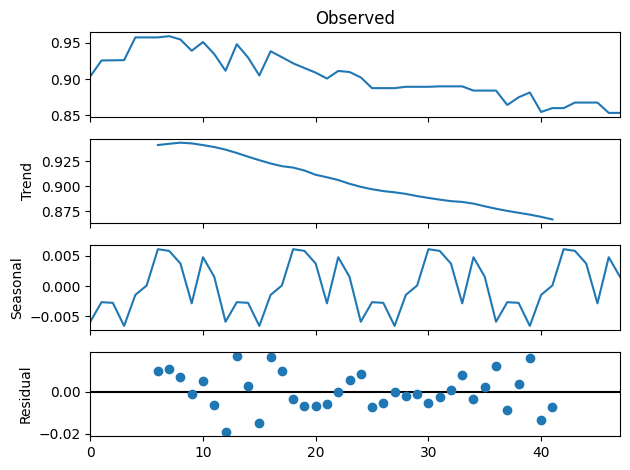

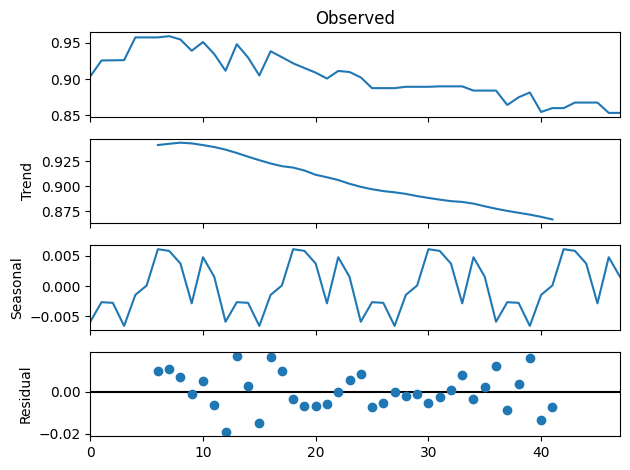

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

USDCHF_pred_list = USDCHF_pred.tolist()
result = seasonal_decompose(USDCHF_pred_list, model='additive', period=12)

result.plot()

In [28]:
dates = list(range(1, 49))  # Assuming you have 48 data points

date_fx = pd.DataFrame(zip(dates, USDCHF_pred_list), columns=['Date', 'USDCHF_Pred'])

date_fx_log = np.log(date_fx['USDCHF_Pred'])


date_fx_log_diff = date_fx_log - date_fx_log.shift(1)

date_fx_log_diff[0] = 0  # Set the first value to 0 after differencing 

y_stationary = date_fx_log_diff

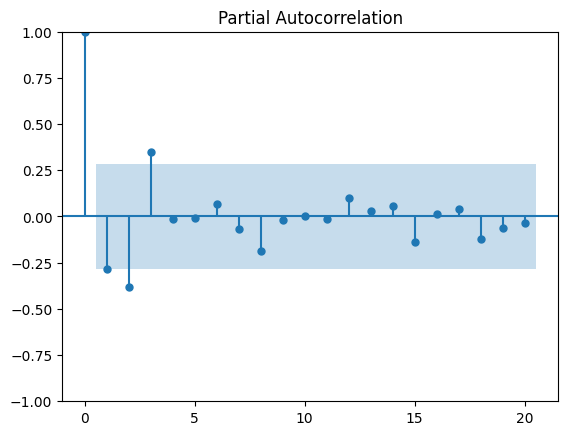

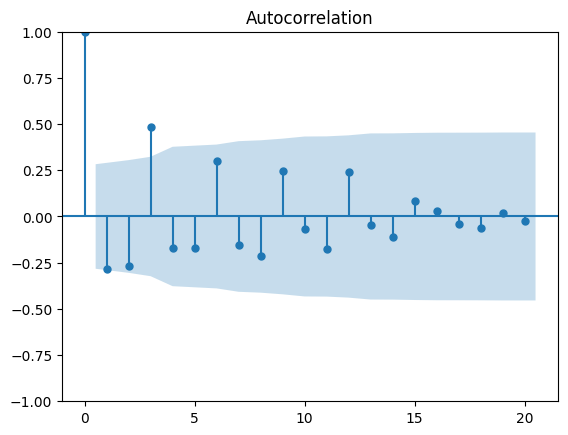

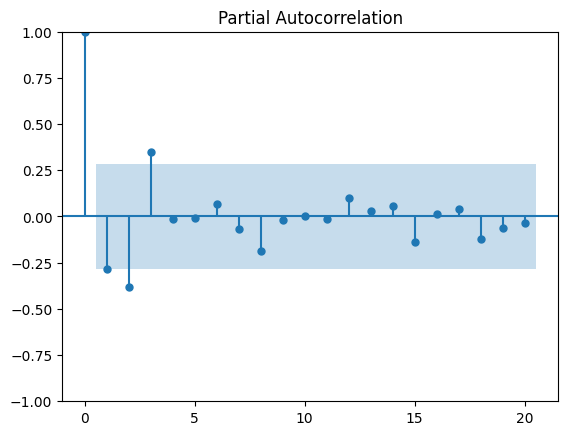

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

date_fx_log_diff = date_fx_log_diff.reshape(-1)

plot_acf(date_fx_log_diff, lags=20)
plot_pacf(date_fx_log_diff, lags=20)


In [43]:
model_arima = ARIMA(y_stationary, order=(2, 1, 1))

model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            USDCHF_Pred   No. Observations:                   48
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 138.135
Date:                Tue, 19 Aug 2025   AIC                           -268.271
Time:                        20:29:27   BIC                           -260.870
Sample:                             0   HQIC                          -265.486
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6191      0.163     -3.801      0.000      -0.938      -0.300
ar.L2         -0.5801      0.120     -4.846      0.000      -0.815      -0.346
ma.L1         -0.6260      0.106     -5.897      0.0

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# Debugging the loop for finding the best model with the lowest AIC
import itertools

p = range(1, 5)
d = range(1, 2)
q = range(1, 4)

pdq = list(itertools.product(p, d, q))
aics = []
params = []

for param in pdq:
    try:
        model = ARIMA(y_stationary, order=param)
        model_arima_fit = model.fit()
        aic = model_arima_fit.aic
        aics.append(aic)
        params.append(param)
    except Exception as e:
        print(f"Error with parameters {param}: {e}")

# Combine AIC values and parameters
combo = list(zip(aics, params))
combo.sort()

# Convert to a pandas DataFrame for better readability
import pandas as pd
combo_df = pd.DataFrame(combo, columns=["AIC", "Parameters"])
print("Best model parameters and AIC values:")
print(combo_df)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local

Best model parameters and AIC values:
           AIC Parameters
0  -268.270962  (2, 1, 1)
1  -268.248670  (3, 1, 1)
2  -267.837993  (2, 1, 2)
3  -266.720683  (2, 1, 3)
4  -266.097317  (3, 1, 2)
5  -265.998999  (4, 1, 1)
6  -264.766535  (3, 1, 3)
7  -263.960451  (4, 1, 2)
8  -262.210694  (4, 1, 3)
9  -261.629544  (1, 1, 3)
10 -258.051587  (1, 1, 1)
11 -253.691856  (1, 1, 2)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48    0.002802
49   -0.008530
50   -0.003140
51    0.000097
52   -0.005034
53   -0.003736
54   -0.001563
55   -0.003661
56   -0.003623
57   -0.002429
58   -0.003190
59   -0.003412
Name: predicted_mean, dtype: float64


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


AttributeError: 'Series' object has no attribute 'get_prediction'

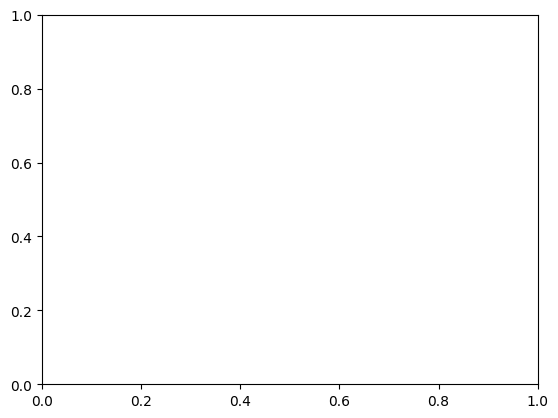

In [50]:
USDCHF_pred_arima = model_arima_fit.forecast(12, alpha = 0.05)

print(USDCHF_pred_arima)

from statsmodels.graphics.tsaplots import plot_predict

USDCHF_pred_arima

[1.0028057303920368,
 0.9915058769086811,
 0.996864606154213,
 1.000096861419894,
 0.9949785650946159,
 0.9962713631383981,
 0.9984383204033151,
 0.9963454574591097,
 0.9963839122961301,
 0.9975736991856036,
 0.9968146479618172,
 0.9965942967892756]